In [ ]:
# κανω τα import που χρειαζονται (παιρετερω αναλυση βρισκετε στο τελος του προγραμματος,για οποιο comment ειναι συνοπτικο)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as SES
from statsmodels.tsa.ar_model import AutoReg as AR
from sklearn.metrics import mean_absolute_error, mean_squared_error
sns.set()
plt.style.use('seaborn-darkgrid')



<ipython-input-2-a344e7df91f6>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [ ]:
# κανω load το dataset
data = pd.read_csv('/content/data (3).csv')

# μετατρεπω το Starttime και endtime σε datetime μεταβλητη
data['StartTime'] = pd.to_datetime(data['StartTime'])
data['EndTime'] = pd.to_datetime(data['EndTime'])


In [ ]:
# δηλωση συναρτηςης για την δημιουργια του demand series με βαση το T
def create_demand_series(data, T):
    # δημιουργια ευρους χρονου απο την πρωτη μερα εως την τελευταια
    start_time = data['StartTime'].min().floor('D')
    end_time = data['EndTime'].max().ceil('D')
    time_index = pd.date_range(start=start_time, end=end_time, freq=T)

    # δηλωση του demand series
    demand_series = pd.Series(0, index=time_index)

    # υπολογισμος του demand για καθε περιοδο
    for _, row in data.iterrows():
        start_interval = row['StartTime'].floor(T)
        end_interval = row['EndTime'].floor(T)

        # τσεκαρω εαν οι περιοδοι ειναι μεσα στο index
        if start_interval in demand_series.index:
            if row['StartStationId'] == 1:
                demand_series[start_interval] -= 1
        if end_interval in demand_series.index:
            if row['EndStationId'] == 1:
                demand_series[end_interval] += 1

    return demand_series


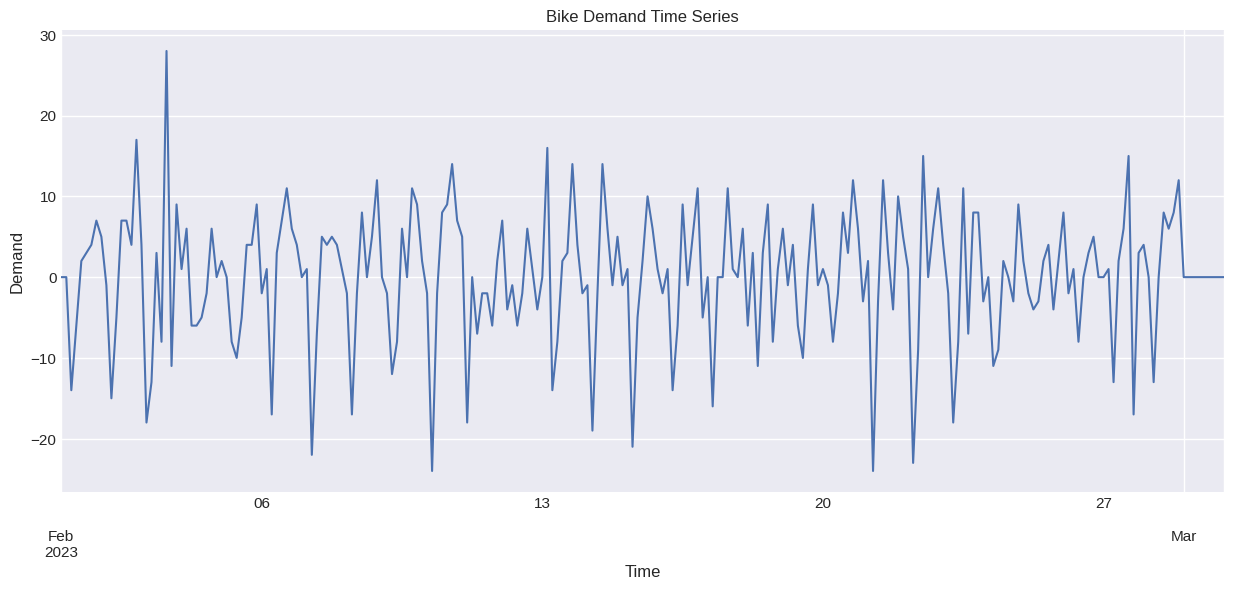

In [ ]:
# δηλωνω την περιοδο
T = '3H'

# καλω την συναρτηση για να φτιαξω το demand_series
demand_series = create_demand_series(data, T)

# πλοτταρω την χρονοσειρα
plt.figure(figsize=(15, 6))
demand_series.plot()
plt.title('Bike Demand Time Series')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

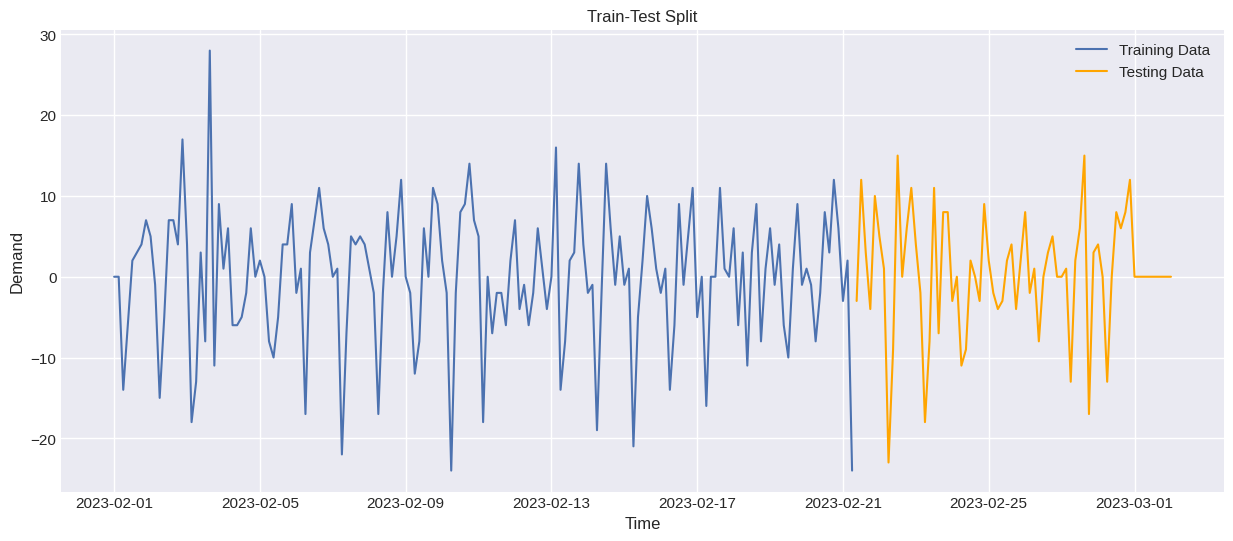

In [ ]:
# κανω split των δεδομενων σε 2 μεταβλητες.Η train_data ειναι το 70% του data και η test_data ειναι το 30%
train_size = int(len(demand_series) * 0.7)
train_data = demand_series[:train_size]
test_data = demand_series[train_size:]

# πλοταρω και τα 2 συνδυαστικα
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.title('Train-Test Split')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


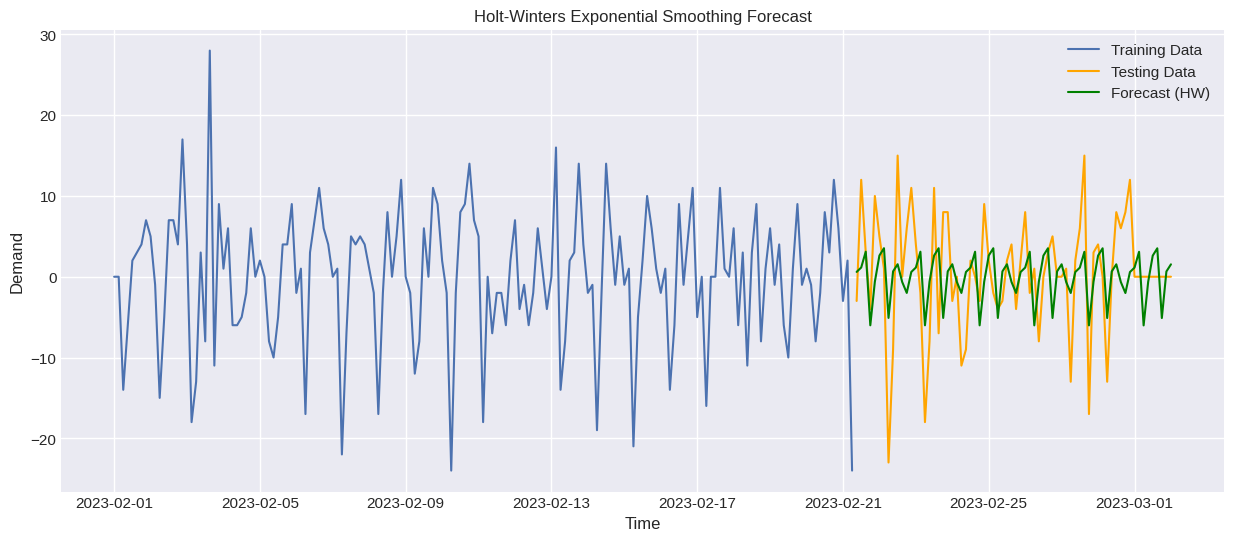

In [ ]:
# κανω φιτ το ExponentialSmoothing
model_hw = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()

# κανω το prediction
forecast_hw = model_hw.forecast(steps=len(test_data))

# και το πλοτταρω
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.plot(forecast_hw, label='Forecast (HW)', color='green')
plt.title('Holt-Winters Exponential Smoothing Forecast')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


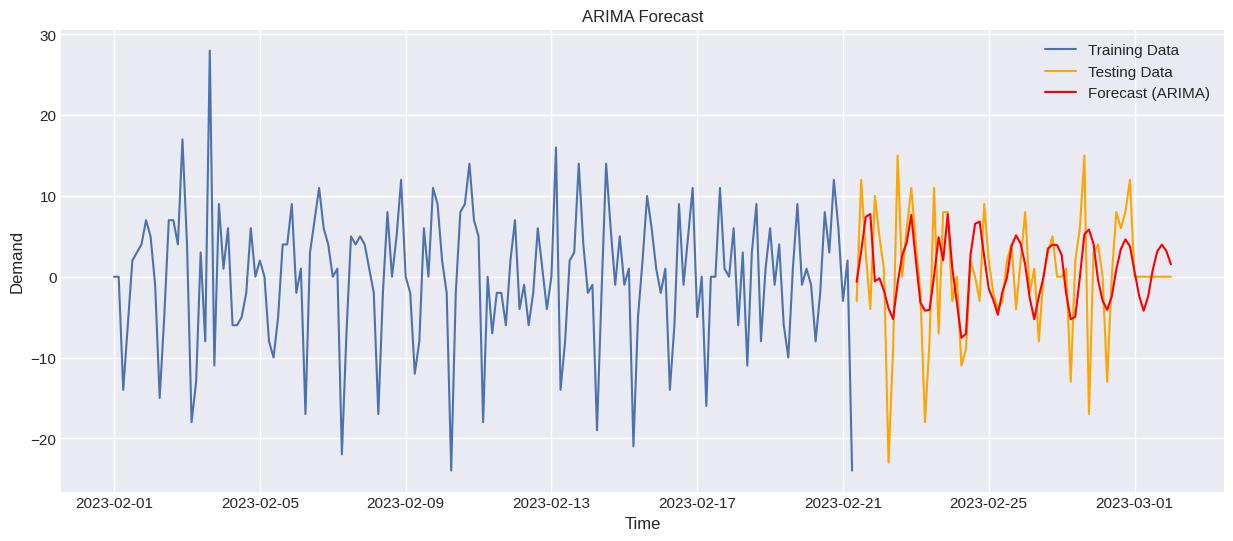

In [ ]:

# κανω φιτ το αριμα μοντελο με παραμετρους που βρηκα οτι ειναι βελτιστοι(δεν ειμαι καθολου σιγουρος για τις παραμετρους,ειναι καθαρα trial&error)
model_arima = ARIMA(train_data, order=(10 , 2, 2)).fit()

# κανω το prediction
forecast_arima = model_arima.forecast(steps=len(test_data))

# ειχα καποια erros τα οποια αναφερονταν σε διαφορα μεγεθους του arima και του test data οποτε εξισωσα το index του αριμα με του test_Data.
forecast_arima.index = test_data.index

# πλοταρω το αποτελεσμα
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.plot(forecast_arima, label='Forecast (ARIMA)', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


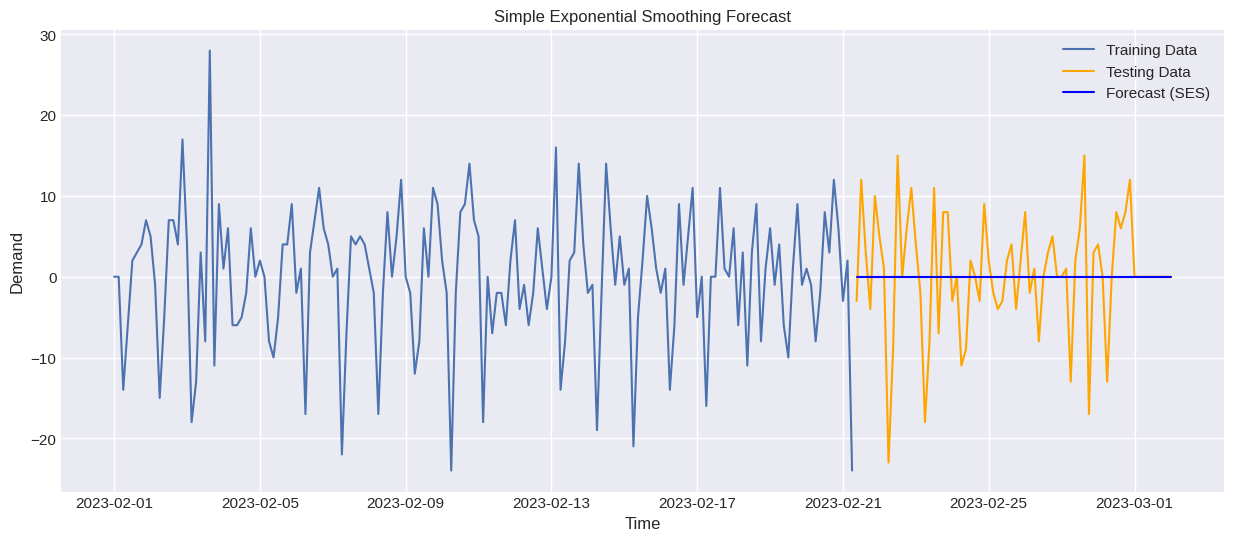

In [ ]:
# φιταρω το απλο exponential smoothing
model_ses = SES(train_data).fit()

# κανω το forecast
forecast_ses = model_ses.forecast(steps=len(test_data))

# το πλοταρω
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.plot(forecast_ses, label='Forecast (SES)', color='blue')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

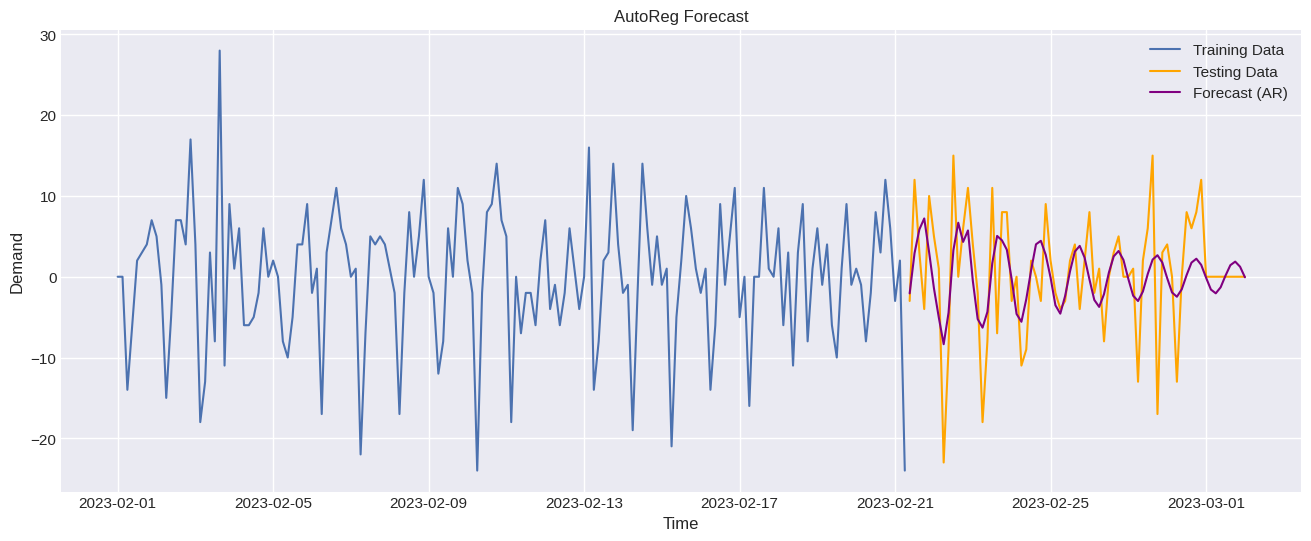

In [ ]:
# φιταρω το AutoReg μοντελο(με lags=16 γιατι ειδα οτι δινει το μικροτερο MAE και RMSE)
model_ar = AR(train_data, lags=16).fit()

# κανω το forecast
forecast_ar = model_ar.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# πλοτταρω το αποτελεσμα
plt.figure(figsize=(16, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.plot(forecast_ar, label='Forecast (AR)', color='purple')
plt.title('AutoReg Forecast')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [ ]:
# αναλυση της επιδοσης των μοντελων με βαση to MAE και το RMSE τους και ενα if statmenet που ελεγχει ποιο μοντελο ειναι καλυτερο με βαση τα ΜΑΕ και RMSE
mae_hw = mean_absolute_error(test_data, forecast_hw)
rmse_hw = mean_squared_error(test_data, forecast_hw, squared=False)
mae_arima = mean_absolute_error(test_data, forecast_arima)
rmse_arima = mean_squared_error(test_data, forecast_arima, squared=False)
mae_ses = mean_absolute_error(test_data, forecast_ses)
rmse_ses = mean_squared_error(test_data, forecast_ses, squared=False)
mae_ar = mean_absolute_error(test_data, forecast_ar)
rmse_ar = mean_squared_error(test_data, forecast_ar, squared=False)

print(f'Holt-Winters MAE: {mae_hw}, RMSE: {rmse_hw}')
print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')
print(f'SES MAE: {mae_ses}, RMSE: {rmse_ses}')
print(f'AutoReg MAE: {mae_ar}, RMSE: {rmse_ar}')
best_mae=min(mae_hw,mae_arima,mae_ses,mae_ar)
best_rmse=min(rmse_hw,rmse_arima,rmse_ses,rmse_ar)
if(best_mae==mae_ar and best_rmse==rmse_ar):
    best_model='AutoReg'
elif(best_mae==mae_arima and best_rmse==rmse_arima):
    best_model='Arima'
elif(best_mae==mae_hw and best_rmse==rmse_hw):
    best_model='Hw exponential smoothing'
elif(best_mae==mae_ses and best_rmse==rmse_ses):
    best_model='Simple Exponential smoothing'
else:
    print(f'den einai ksekatharo poio montelo einai to kalytero')
print(f'to kalytero montelo einai: {best_model}')

Holt-Winters MAE: 5.402759387311018, RMSE: 6.81210808149898
ARIMA MAE: 4.931273333732032, RMSE: 6.657373061598804
SES MAE: 5.185714351279354, RMSE: 7.341661947078455
AutoReg MAE: 4.738766838401115, RMSE: 6.255156192078301
The best model is: AutoReg


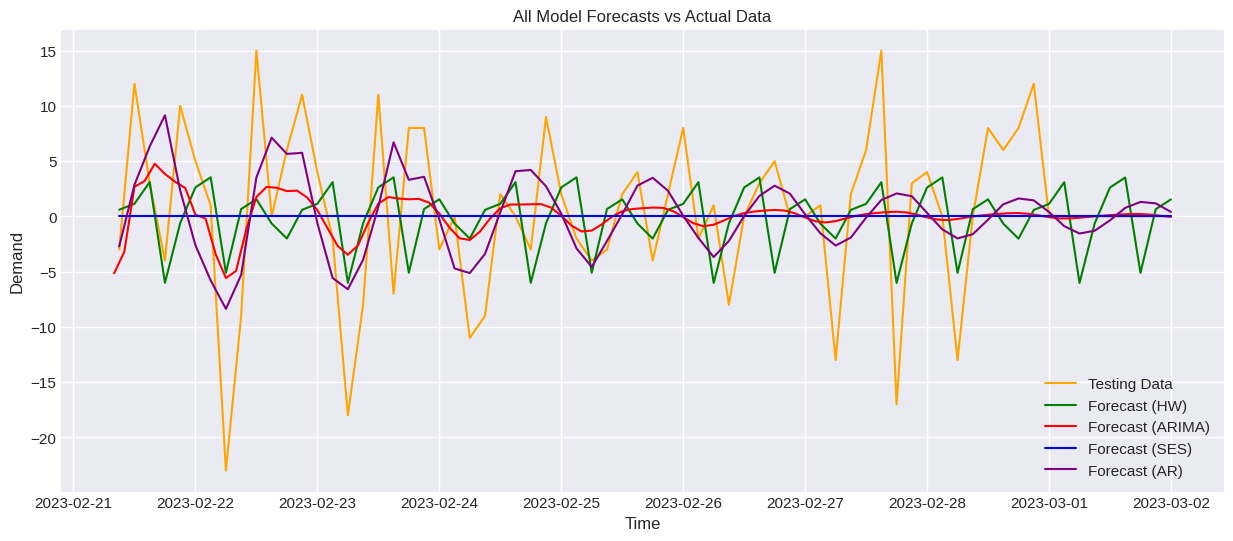

In [ ]:
# πλοταρω ολα τα predicitons μαζι με το training data
plt.figure(figsize=(15, 6))
plt.plot(test_data, label='Testing Data', color='orange')

plt.plot(forecast_hw, label='Forecast (HW)', color='green')
plt.plot(forecast_arima, label='Forecast (ARIMA)', color='red')
plt.plot(forecast_ses, label='Forecast (SES)', color='blue')
plt.plot(forecast_ar, label='Forecast (AR)', color='purple')

plt.title('All Model Forecasts vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

Σκεπτικο επιλυσης προγραμματιστικης ασκησης


εισαγωγη βιβλιοθηκων:

pandas για επεξεργασια δεδομενων και χρηση dataframes
numpy για αριμθιτικους υπολογισμους
matplotlib.pyplot και seaborn για οπτικοποιηση.
ExponentialSmoothing, ARIMA, SimpleExpSmoothing και AutoReg από το statsmodels.tsa για ανάλυση και προβλεψη των χρονοσειρων.
mean_absolute_error και mean_squared_error από το sklearn.metrics για αγιολογηση των μοντελων.

Αρχικα φορτονουμε τα δεδομενα μεσω του csv μεσω της pd.read_csv().
Μετα μετατρεπωω τις στηλες Start_time και end_time σε μορφη ημερομινιας με την pd.to_datetime().

Στην συνεχεια οριζω το διαστημα χρονου Τ:

Οριζω το χρονικο διαστημα Τ το οποιο διχνει την περιοδο που συγκεντρωνουμε την ζητηση για τα ποδηλατα.Η τιμη αυτη μπορει να αλλαξει με σκοπο καλυτερης προβλεψης,με καποιες δοκιμες κατεληξα οτι το 3 η 2 ειναι ισως το καλυτερο για την προβλεψη που κανουμε.

Μετα οριζω την χρονοσειρα ζητησης

οριζω μια συναρτηση create_demand_series() για την δημιουργια της χρονοσειρας ζητησης με βαση το διαστημα Τ.Μεσα σε αυτη τη συναρτηση

Μεσα σε αυτη τη συναρτηση:
φτιαχνω ενα ευρος χρονου βασισμενο στα δεδομενα, ξεκινωντας απο το ελαχιστο 'StartTime' στρογγυλεμενο προς τα κατω στην πλησιεστερη ημερα (floor('D')) και τελειωνοντας στο μεγιστο 'EndTime' στρογγυλεμενο προς τα πανω στην πλησιεστερη ημερα (ceil('D')).
Υπολογιζουμε τη ζητηση για καθε χρονικο διαστημα επαναλαμβανοντας το dataset και παιρνοντας υποψη τα ποδηλατα που φευγουν η γυρνανε σε station με id=1

Οπτικοποιηση της χρονοσειρας ζητησης:

φτιαχνω ενα απλο γραφημα της χρονοσειρας ωστε να δειξω την ζητηση σε βαθος χρονου.

Διαχωρισμος των δεδομενων σε εκπαιδευση και ελεγχο:

Διαχωριζουμε τη χρονοσειρα σε συνολα εκπαιδευσης και ελεγχου. Το πρωτο κομματι της χρονοσειρας 70% αποτελει τα δεδομενα εκπαιδευσης, ενω το επομενο κομματι 30% αποτελει τα δεδομενα ελεγχου.

Προσαρμογη,προβλεψη και αξιολογηση Μοντελων:

εφαρμοζω ολα τα μοντελα προβλεψης και στην συνεχεια τα κανω evaluate μεσω των MAE και RMSE για καθε μοντελο.

Τελος φτιαχνω ενα plot το οποιο αποτελειτε απο ολα τα μοντελα προβλεψης καθως και απο το train_data ετσι ωστε να δειξει σε οπτιοκοποιημενη μορφη πως ανταποκριθηκε το καθε μοντελο στην προβλεψη της χρονοσειρας,Το αποτελεσμα ειναι λιγο χαοδες οποτε ο καλυτερος τροπος για να καταλαβουμε ποιο ειναι το καλυτερο μοντελο ειναι τα MAE και RMSE.Απο αυτες τις τιμες παρατηρησα οτι το AutoReg μοντελο ανταποκρινετε συνηθως καλυτερα στην προβλεψη,στην συνεχεια το ARIMA και μετα το Holt-Winters exponential smoothing και τελος το simple exponential smoothing το οποιο ειναι απλα μια ευθεια στη μεση της χρονοσειρας οποτε κατι μπορει να εχω κανει λαθος.Γενικα αυτη η καταταξη των μοντελων αλλαζει αλλαζοντας και τις παραμετρους στις οποιες κανουν fit,κατεληξα ομως σε αυτες μετα απο διαφορα test.





